In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jun-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jun-2021/train.csv
/kaggle/input/tabular-playground-series-jun-2021/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/tabular-playground-series-jun-2021/train.csv")
test = pd.read_csv("/kaggle/input/tabular-playground-series-jun-2021/test.csv")
ss = pd.read_csv("/kaggle/input/tabular-playground-series-jun-2021/sample_submission.csv")

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_rows', 100)

In [5]:
print(f'Shape of Train dataset is : {train.shape}')
print(f'Shape of Test dataset is : {test.shape}')
print(f'Shape of Sample Submission dataset is : {ss.shape}')

Shape of Train dataset is : (200000, 77)
Shape of Test dataset is : (100000, 76)
Shape of Sample Submission dataset is : (100000, 10)


In [6]:
def check_NAN_columns(df, df_name):
    if len(df.columns[df.isnull().any()]) == 0:
        print(f'No missing data in {df_name} dataset')
    else:
        print(f'The following columns are having missing data in {df_name} dataset:')
        print(df.columns[df.isnull().any()])
        
datasets = {
    'Train': train,
    'Test': test,
    'Sample Submission': ss,
}
for df_name, df in datasets.items():
    check_NAN_columns(df, df_name)

No missing data in Train dataset
No missing data in Test dataset
No missing data in Sample Submission dataset


In [7]:
train.drop(columns=['id']).describe().T


,count,mean,std,min,25%,50%,75%,max
feature_0,200000.0,0.972710,3.941836,0.0,0.0,0.0,1.0,61.0
feature_1,200000.0,1.168365,3.993407,0.0,0.0,0.0,1.0,51.0
feature_2,200000.0,2.219325,6.476570,0.0,0.0,0.0,1.0,64.0
feature_3,200000.0,2.296735,7.551858,0.0,0.0,0.0,1.0,70.0
feature_4,200000.0,0.793530,2.935785,0.0,0.0,0.0,0.0,38.0
feature_5,200000.0,1.431105,5.162746,0.0,0.0,0.0,1.0,76.0
feature_6,200000.0,1.010695,3.949231,0.0,0.0,0.0,0.0,43.0
feature_7,200000.0,0.673090,2.234949,0.0,0.0,0.0,0.0,30.0
feature_8,200000.0,1.943980,3.931330,0.0,0.0,0.0,2.0,38.0
feature_9,200000.0,1.719655,5.916988,0.0,0.0,0.0,1.0,72.0


In [8]:
test.drop(columns=['id']).describe().T

,count,mean,std,min,25%,50%,75%,max
feature_0,100000.0,0.99051,4.018930,0.0,0.0,0.0,1.0,61.0
feature_1,100000.0,1.16852,4.030234,0.0,0.0,0.0,1.0,51.0
feature_2,100000.0,2.18273,6.402817,0.0,0.0,0.0,1.0,64.0
feature_3,100000.0,2.31624,7.584742,0.0,0.0,0.0,1.0,70.0
feature_4,100000.0,0.79205,2.938386,0.0,0.0,0.0,0.0,38.0
feature_5,100000.0,1.43552,5.164174,0.0,0.0,0.0,1.0,76.0
feature_6,100000.0,1.01693,3.956569,0.0,0.0,0.0,0.0,43.0
feature_7,100000.0,0.67978,2.262651,0.0,0.0,0.0,0.0,30.0
feature_8,100000.0,1.94537,3.938406,0.0,0.0,0.0,2.0,38.0
feature_9,100000.0,1.71610,5.876687,0.0,0.0,0.0,1.0,72.0


Text(0.5, 1.0, 'Target Distribution')

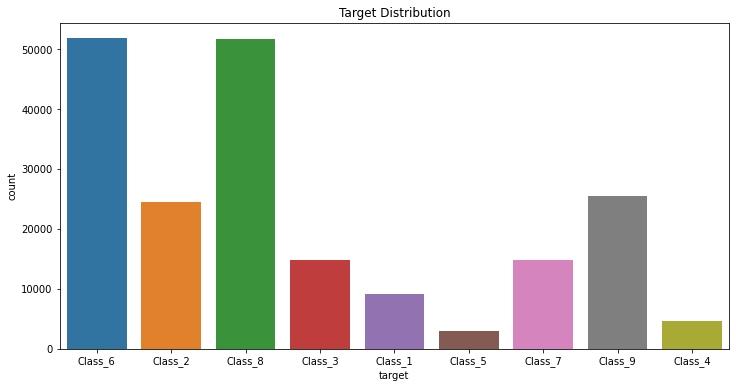

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x='target', data=train)
ax.set_title('Target Distribution')

In [10]:
X = train.drop(["id","target"], axis=1)
y = train.target
X_test = test.drop("id", axis=1)

In [11]:
iterations = 100
lgbm_pred = 0
logloss = []
for i in tqdm_notebook(range(iterations)):
    random_state = np.random.randint(0,2000)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y , test_size=0.2, stratify=y, random_state=random_state)
    lgbm = LGBMClassifier(random_state=random_state)
    lgbm.fit(X_train,y_train)
    valid_preds = lgbm.predict_proba(X_valid)
    lgbm_pred += lgbm.predict_proba(X_test)/iterations
    logloss.append(log_loss(y_valid,valid_preds))
    print(f'Iteration {i} : Random State = {random_state}, Log Loss = {log_loss(y_valid,valid_preds)}')
print(f'Average Log Loss = {sum(logloss)/len(logloss)}')

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0 : Random State = 1666, Log Loss = 1.755679298444384
Iteration 1 : Random State = 66, Log Loss = 1.756215629008906
Iteration 2 : Random State = 687, Log Loss = 1.7532546542130247
Iteration 3 : Random State = 834, Log Loss = 1.754414544105224
Iteration 4 : Random State = 1810, Log Loss = 1.7559875452606324
Iteration 5 : Random State = 1226, Log Loss = 1.7581343579100772
Iteration 6 : Random State = 1511, Log Loss = 1.7567356442220772
Iteration 7 : Random State = 1845, Log Loss = 1.7608301502815096
Iteration 8 : Random State = 774, Log Loss = 1.7558813257251056
Iteration 9 : Random State = 1764, Log Loss = 1.756899450565393
Iteration 10 : Random State = 1578, Log Loss = 1.7612037907111182
Iteration 11 : Random State = 1843, Log Loss = 1.7518545392603873
Iteration 12 : Random State = 566, Log Loss = 1.7540968690647551
Iteration 13 : Random State = 1676, Log Loss = 1.7566171221017528
Iteration 14 : Random State = 1747, Log Loss = 1.7593732193141176
Iteration 15 : Random State = 

In [12]:
ss["Class_1"] = lgbm_pred[:,0]
ss["Class_2"] = lgbm_pred[:,1]
ss["Class_3"] = lgbm_pred[:,2]
ss["Class_4"] = lgbm_pred[:,3]
ss["Class_5"] = lgbm_pred[:,4]
ss["Class_6"] = lgbm_pred[:,5]
ss["Class_7"] = lgbm_pred[:,6]
ss["Class_8"] = lgbm_pred[:,7]
ss["Class_9"] = lgbm_pred[:,8]
ss.to_csv("/kaggle/working/lgbm_100_ensemble_sub.csv", index=False)